In [1]:
!nvidia-smi

Fri Jul 21 09:18:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install -qq transformers

In [3]:
import transformers
import torch
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from sqlalchemy.util import defaultdict


import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from tqdm import tqdm

from torch import nn, optim
from torch.utils import data
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette ='muted', font_scale = 1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import warnings
warnings.filterwarnings('ignore')

# Set the default data type for numpy to int32
np.seterr(all='ignore')
np.set_printoptions(precision=4, suppress=True)
np.seterr(over='ignore')


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [4]:
!gdown --id 1hqhvLJMkyqKsaJ5GiXkTcXKWcF0S_QJF
!gdown --id 1hE0V_o3NwcoFo0EMaHBd6YvMuqablEA5


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hqhvLJMkyqKsaJ5GiXkTcXKWcF0S_QJF
To: /content/test.tsv
100% 2.88M/2.88M [00:00<00:00, 55.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hE0V_o3NwcoFo0EMaHBd6YvMuqablEA5
To: /content/train.tsv
100% 6.88M/6.88M [00:00<00:00, 99.9MB/s]


In [5]:
df_train = pd.read_csv("/content/train.tsv", sep ='\t' )
df_test = pd.read_csv("/content/test.tsv", sep= '\t')

print(df_train.head())
print(df_test.head())

           PID                                          Text_data     Label
0  train_pid_1  Waiting for my mind to have a breakdown once t...  moderate
1  train_pid_2  My new years resolution : I'm gonna get my ass...  moderate
2  train_pid_3  New year : Somone else Feeling like 2020 will ...  moderate
3  train_pid_4  My story I guess : Hi, Im from Germany and my ...  moderate
4  train_pid_5  Sat in the dark and cried myself going into th...  moderate
          Pid                                          text data Class labels
0  test_pid_1  Im scared : This is it. I lie to myself every ...     moderate
1  test_pid_2  New to this but just wanted to vent : I just f...     moderate
2  test_pid_3  I’m sad : It’s kinda always been an issue. I w...     moderate
3  test_pid_4  Lonely but not alone. : All of my immediately ...     moderate
4  test_pid_5  This year has been trash. : I dont know why I’...     moderate


In [6]:
# Rename columns in df_train
df_train = df_train.rename(columns={'PID': 'PID', 'Text_data': 'text', 'Label': 'sentiment'})

# Rename columns in df_test
df_test = df_test.rename(columns={'Pid': 'PID', 'text data': 'text', 'Class labels': 'sentiment'})


In [7]:
df1_train = df_train.copy()
df2_train = df_train.copy()
df1_test = df_test.copy
print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

moderate          6004
not depression    1985
severe             902
Name: sentiment, dtype: int64
moderate          2169
not depression     848
severe             228
Name: sentiment, dtype: int64


In [8]:
# Create a LabelEncoder object

def encode_labels(df, column):
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    return df


df_train = encode_labels(df_train, 'sentiment')
df_test = encode_labels(df_test, 'sentiment')

print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

0    6004
1    1985
2     902
Name: sentiment, dtype: int64
0    2169
1     848
2     228
Name: sentiment, dtype: int64


This code creates three different datasets (data_set_1, data_set_2, data_set_3) with different class distributions. data_set_1 has all classes balanced to the size of the minority class (902 instances each). data_set_2 has the majority class 0 downsampled to match the size of class 1 (1985 instances). data_set_3 has the majority class 0 downsampled to a specified size (3000 instances). The downsampling is done without replacement to ensure diversity in the samples.

In [9]:
%%time
# Separate majority and minority classes
df_majority_0 = df_train[df_train.sentiment==0]
df_majority_1 = df_train[df_train.sentiment==1]
df_minority = df_train[df_train.sentiment==2]

# Downsample majority class 0 to match the minority class size (902)
df_majority_0_downsampled = resample(df_majority_0,
                                 replace=False,    # sample without replacement
                                 n_samples=902,     # to match minority class
                                 random_state=123) # reproducible results

# Downsample majority class 1 to match the minority class size (902)
df_majority_1_downsampled = resample(df_majority_1,
                                 replace=False,    # sample without replacement
                                 n_samples=902,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority classes to create data_set_1
data_set_1 = pd.concat([df_majority_0_downsampled, df_majority_1_downsampled, df_minority])

# Display new class counts for data_set_1
print(data_set_1.sentiment.value_counts())

# Downsample majority class 0 to match the size of class 1 (1985) for data_set_2
df_majority_0_downsampled_set2 = resample(df_majority_0,
                                 replace=False,    # sample without replacement
                                 n_samples=1985,     # to match class 1
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class to create data_set_2
data_set_2 = pd.concat([df_majority_0_downsampled_set2, df_majority_1, df_minority])

# Display new class counts for data_set_2
print(data_set_2.sentiment.value_counts())

# Downsample majority class 0 to a specified size (3000) for data_set_3
df_majority_0_downsampled_set3 = resample(df_majority_0,
                                 replace=False,    # sample without replacement
                                 n_samples=3000,     # to match class 1
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class to create data_set_3
data_set_3 = pd.concat([df_majority_0_downsampled_set3, df_majority_1, df_minority])

# Display new class counts for data_set_3
print(data_set_3.sentiment.value_counts())


0    902
1    902
2    902
Name: sentiment, dtype: int64
0    1985
1    1985
2     902
Name: sentiment, dtype: int64
0    3000
1    1985
2     902
Name: sentiment, dtype: int64
CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 15.3 ms


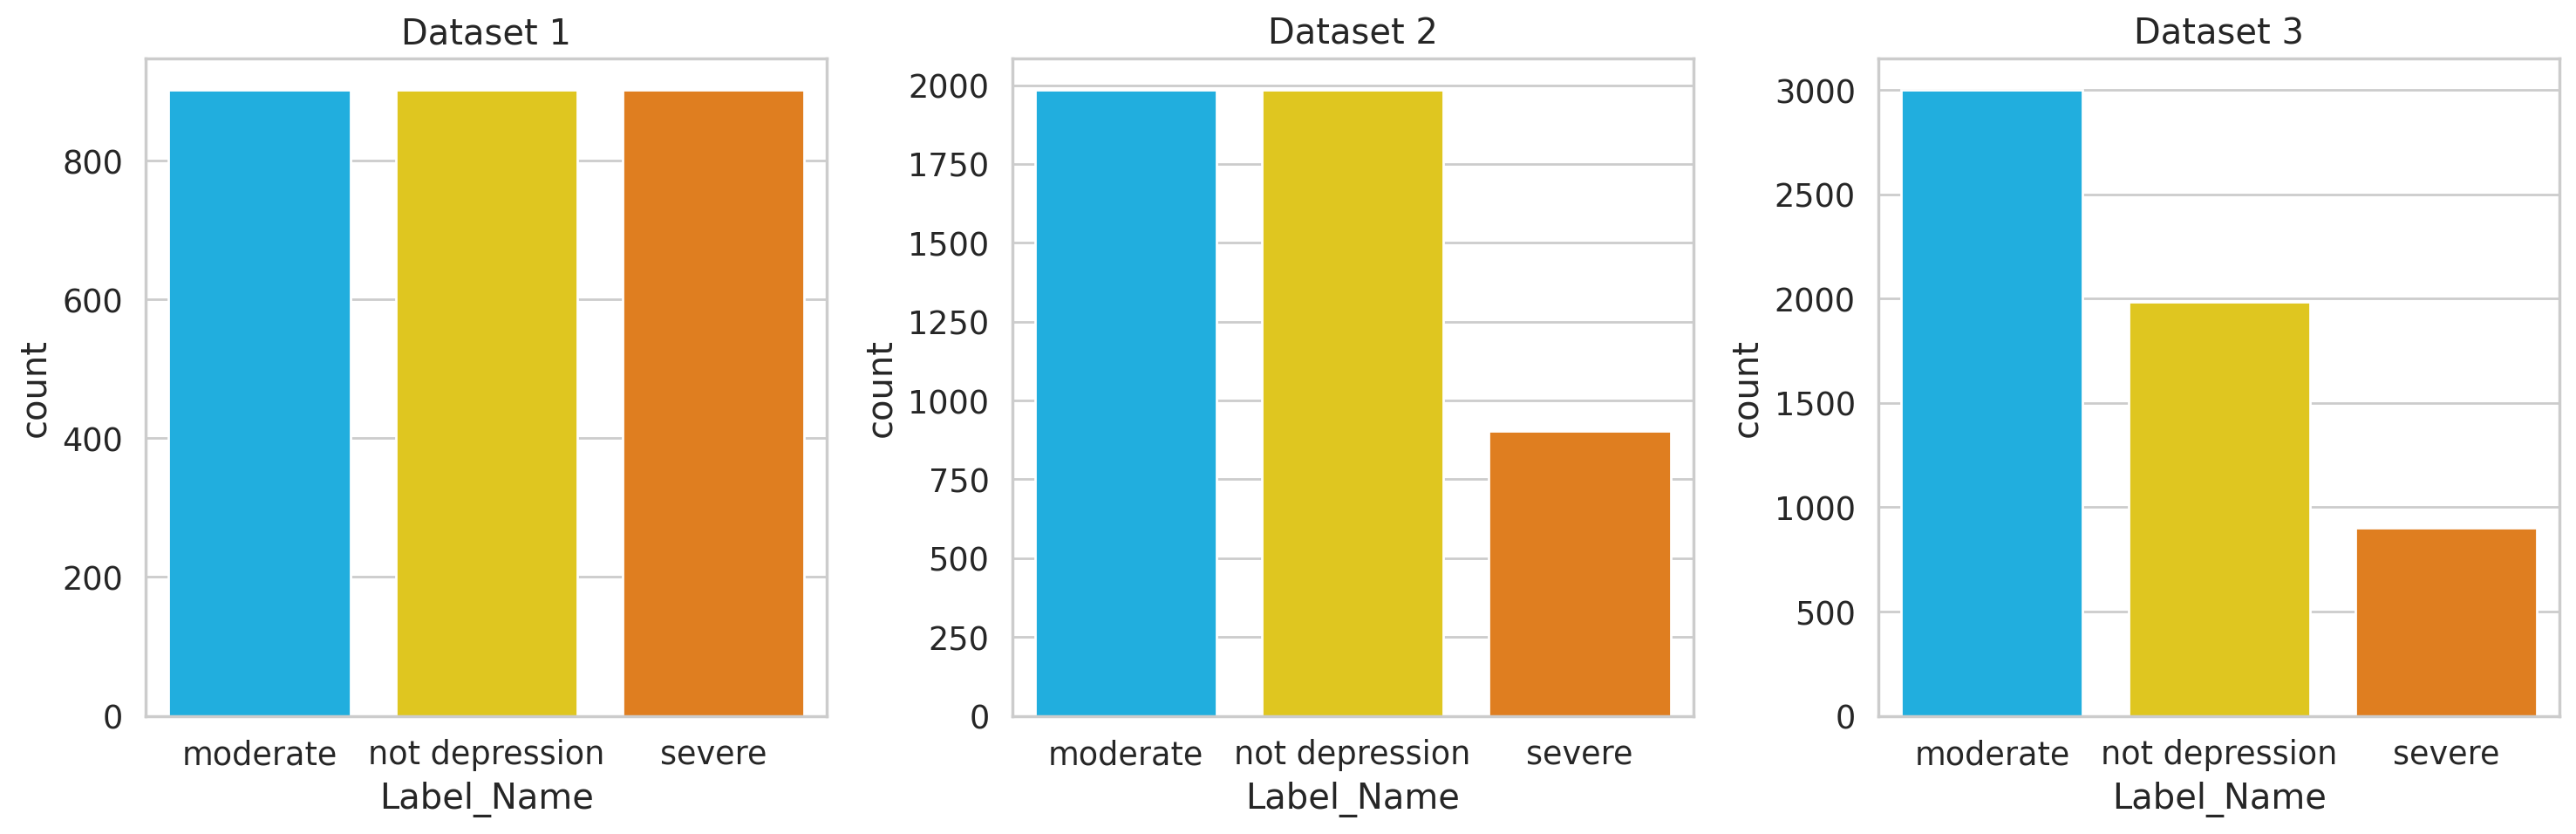

In [10]:
# Create a mapping for the labels
label_dict = {0: 'moderate', 1: 'not depression', 2: 'severe'}

# Create a new column 'Label_Name' in each dataset
data_set_1['Label_Name'] = data_set_1['sentiment'].map(label_dict)
data_set_2['Label_Name'] = data_set_2['sentiment'].map(label_dict)
data_set_3['Label_Name'] = data_set_3['sentiment'].map(label_dict)

# Create countplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='Label_Name', data=data_set_1)
plt.title('Dataset 1')

plt.subplot(1, 3, 2)
sns.countplot(x='Label_Name', data=data_set_2)
plt.title('Dataset 2')

plt.subplot(1, 3, 3)
sns.countplot(x='Label_Name', data=data_set_3)
plt.title('Dataset 3')

plt.tight_layout()
plt.show()


# Data Preprocessing

In [11]:
# Load PHS-BERT
PRE_TRAINED_MODEL_NAME = "publichealthsurveillance/PHS-BERT"
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of BertModel were not initialized from the model checkpoint at publichealthsurveillance/PHS-BERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
%%time
sample_text = 'I have been feeling depressed for a few weeks now. I do not have any motivation to do anything'

tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'Sentence: {sample_text}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
  sample_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

print(encoding['input_ids'])

Sentence: I have been feeling depressed for a few weeks now. I do not have any motivation to do anything
Tokens: ['i', 'have', 'been', 'feeling', 'depressed', 'for', 'a', 'few', 'weeks', 'now', '.', 'i', 'do', 'not', 'have', 'any', 'motivation', 'to', 'do', 'anything']
Token IDs: [1045, 2031, 2042, 3110, 14777, 2005, 1037, 2261, 3134, 2085, 1012, 1045, 2079, 2025, 2031, 2151, 14354, 2000, 2079, 2505]
tensor([[  101,  1045,  2031,  2042,  3110, 14777,  2005,  1037,  2261,  3134,
          2085,  1012,  1045,  2079,  2025,  2031,  2151, 14354,  2000,  2079,
          2505,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
CPU times: user 3.66 ms, sys: 935 µs, total: 4.6 ms
Wall time: 4.65 ms


# Choosing Sequence Length

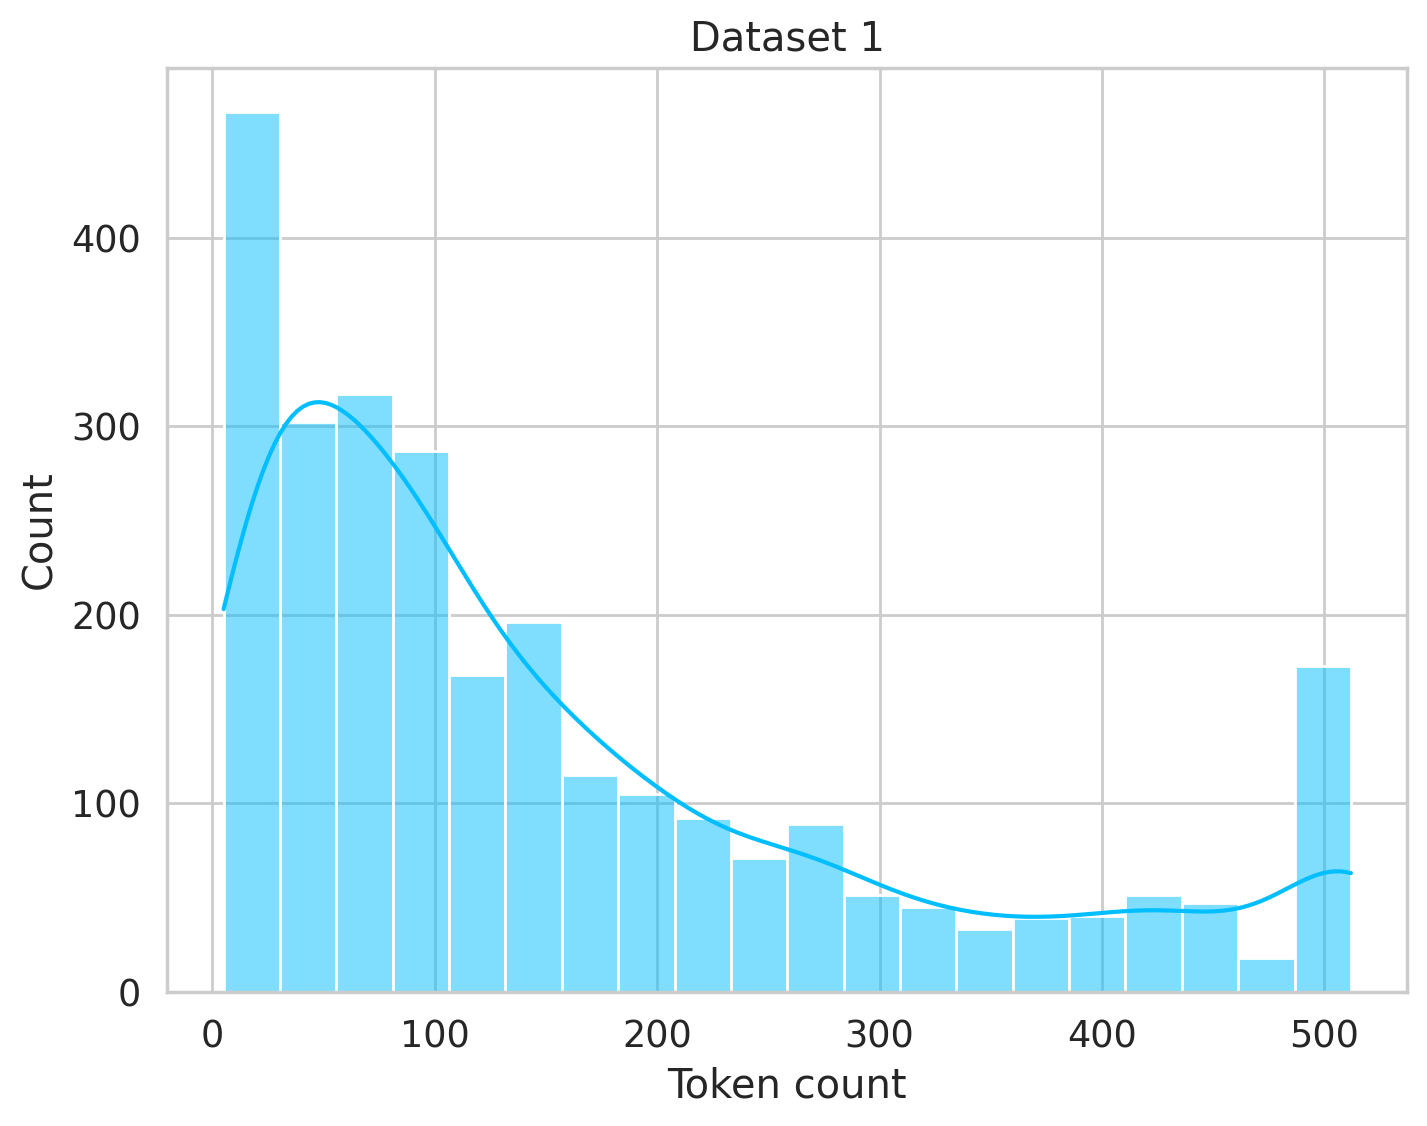

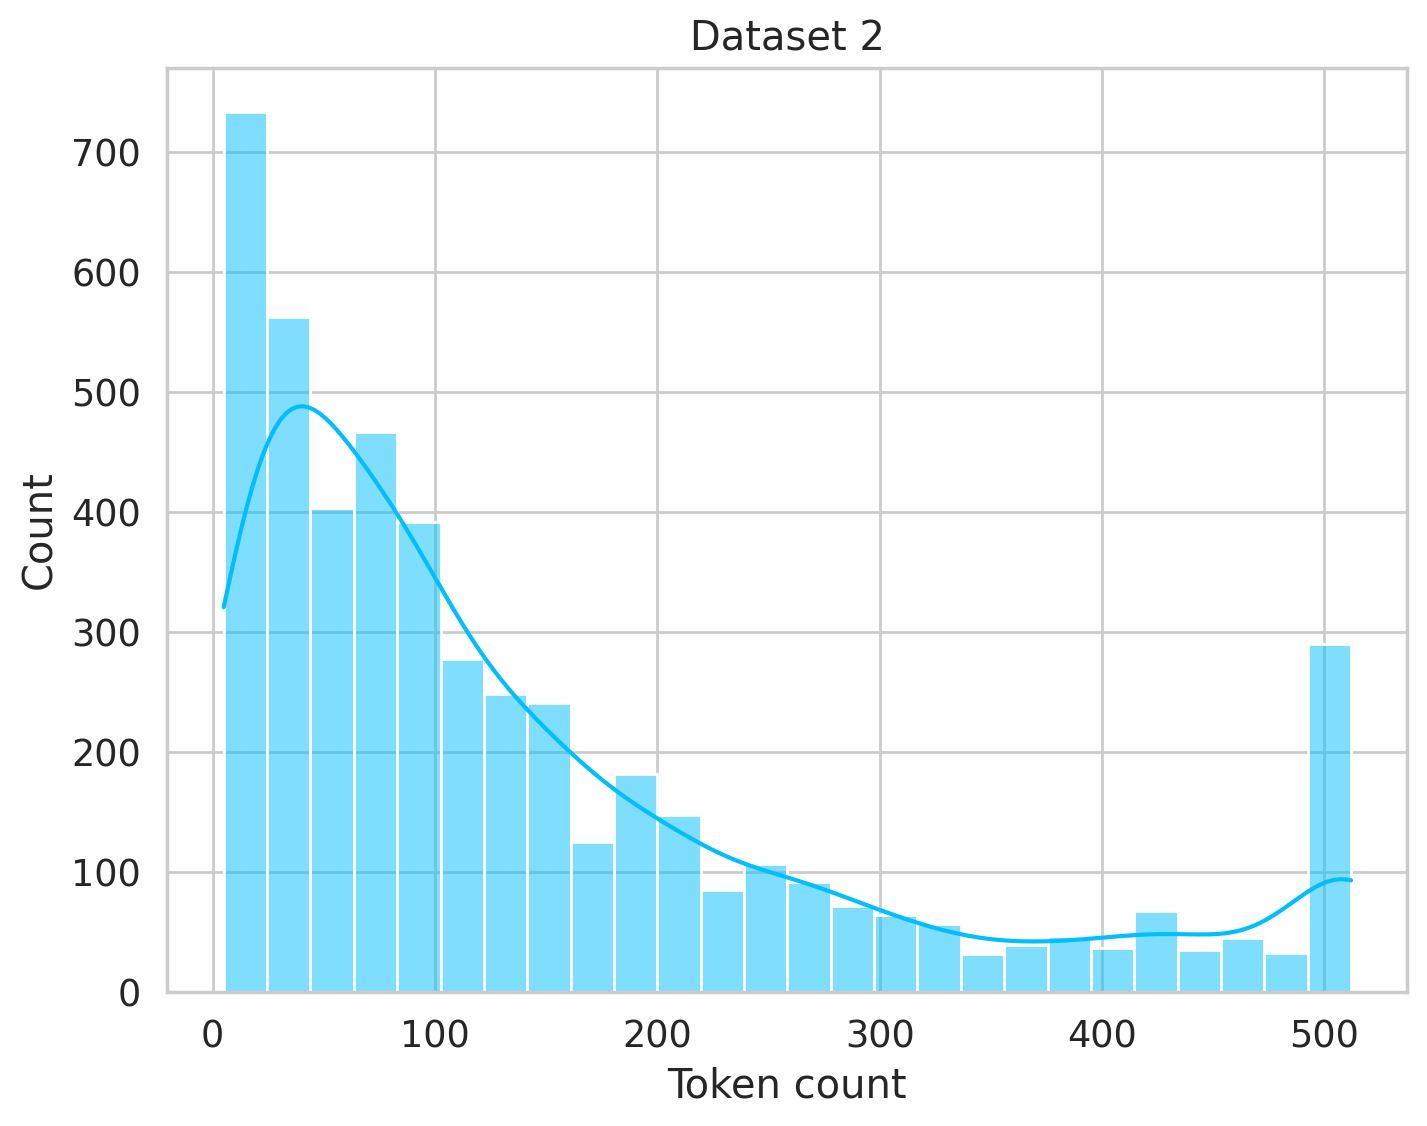

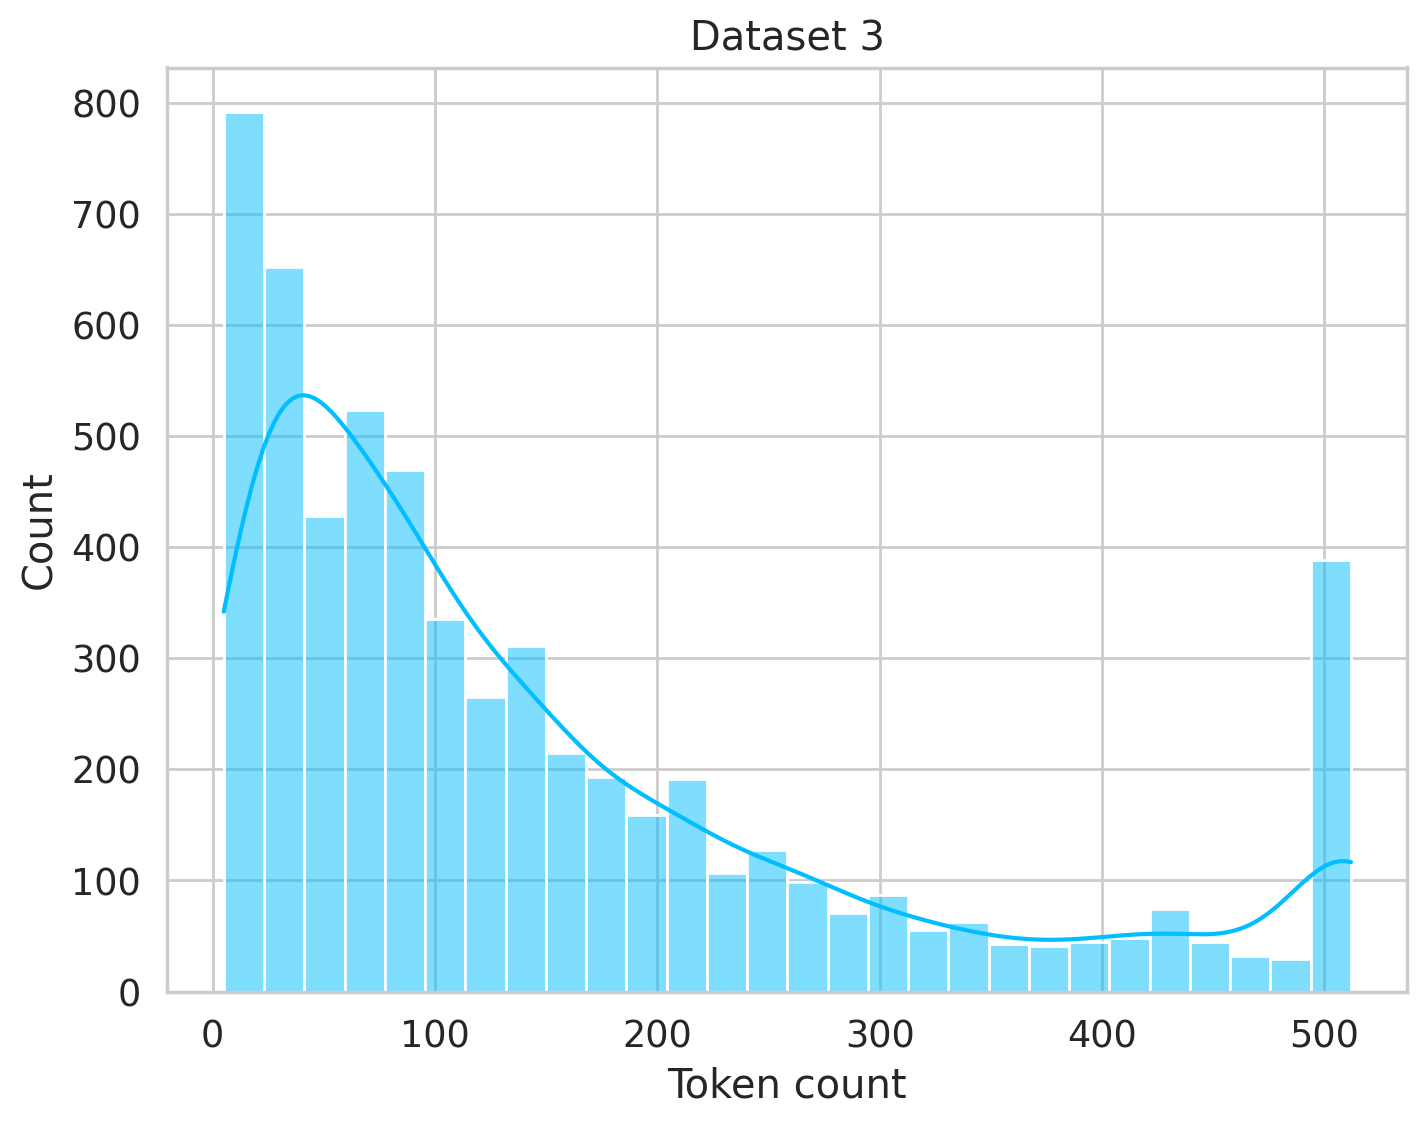

In [13]:
datasets = [data_set_1, data_set_2, data_set_3]
dataset_names = ['Dataset 1', 'Dataset 2', 'Dataset 3']

for i, df in enumerate(datasets):
    token_lens = []
    for txt in df['text']:
        tokens = tokenizer.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))

    plt.figure(i)
    sns.histplot(token_lens, kde=True)
    plt.xlabel('Token count')
    plt.title(dataset_names[i])
    plt.show()


## Dataset 1

In [14]:

class GPReviewDataset(data.Dataset):

  def __init__(self, review, targets, tokenizer, max_len):
    self.review = review
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [15]:
MAX_LEN = 200
BATCH_SIZE = 18
EPOCHS = 10

In [16]:
data_set_1_train, data_set_1_val = train_test_split(data_set_2, test_size=0.20, random_state=RANDOM_SEED)
data_set_1_train.shape, data_set_1_val.shape

((3897, 4), (975, 4))

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df['text'].to_numpy(),
      targets = df['sentiment'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return data.DataLoader(
      ds,
      batch_size = batch_size,
      num_workers =2
  )


In [18]:
train_set_1_data_loader = create_data_loader(data_set_1_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_set_1_data_loader = create_data_loader(data_set_1_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
class SentimentClassifier(nn.Module):

  def __init__ (self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [20]:
num_classes = data_set_1['sentiment'].nunique()
num_classes

3

In [21]:
model = SentimentClassifier(num_classes)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at publichealthsurveillance/PHS-BERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
batch_data = next(iter(train_set_1_data_loader))
input_ids = batch_data['input_ids'].to(device)
attention_mask = batch_data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

print(type(batch_data['input_ids']))
print(type(batch_data['attention_mask']))

torch.Size([18, 200])
torch.Size([18, 200])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [23]:
"""output = model(input_ids, attention_mask)
probabilities = F.softmax(output, dim=1)
probabilities"""

'output = model(input_ids, attention_mask)\nprobabilities = F.softmax(output, dim=1)\nprobabilities'

## Training

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_set_1_data_loader)* EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):


  model = model.train()
  losses=[]
  correct_predictions = 0


  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


  return correct_predictions.double()/n_examples, np.mean(losses)

In [26]:
def eval_model(model,data_loader,loss_fn,device,n_examples):


  model = model.eval()
  losses=[]
  correct_predictions = 0

  with torch.no_grad():



    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids, attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())


  return correct_predictions.double()/n_examples, np.mean(losses)

In [27]:
%%time

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-'*10)

  train_acc, train_loss = train_epoch(
      model,
      train_set_1_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(data_set_1_train)
  )

  print(f'Trian loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_set_1_data_loader,
      loss_fn,
      device,
      len(data_set_1_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Trian loss 0.6579807963102094 accuracy 0.707980497818835
Val loss 0.5354041183536703 accuracy 0.7589743589743589

Epoch 2/10
----------
Trian loss 0.25737652057043625 accuracy 0.9058249935848088
Val loss 0.4962377932769331 accuracy 0.8482051282051282

Epoch 3/10
----------
Trian loss 0.09030181015648532 accuracy 0.9727995894277649
Val loss 0.7283806937132877 accuracy 0.8615384615384616

Epoch 4/10
----------
Trian loss 0.04927500290460863 accuracy 0.9871696176546061
Val loss 0.844717844761908 accuracy 0.8707692307692307

Epoch 5/10
----------
Trian loss 0.030329503931484963 accuracy 0.9925583782396715
Val loss 0.8044431134611262 accuracy 0.8728205128205129

Epoch 6/10
----------
Trian loss 0.021280098652970345 accuracy 0.9946112394149346
Val loss 0.9095035972622678 accuracy 0.8574358974358974

Epoch 7/10
----------
Trian loss 0.01640240449241356 accuracy 0.9958942776494739
Val loss 0.8570402471674077 accuracy 0.8687179487179487

Epoch 8/10
----------
Trian loss 0.

(0.0, 1.0)

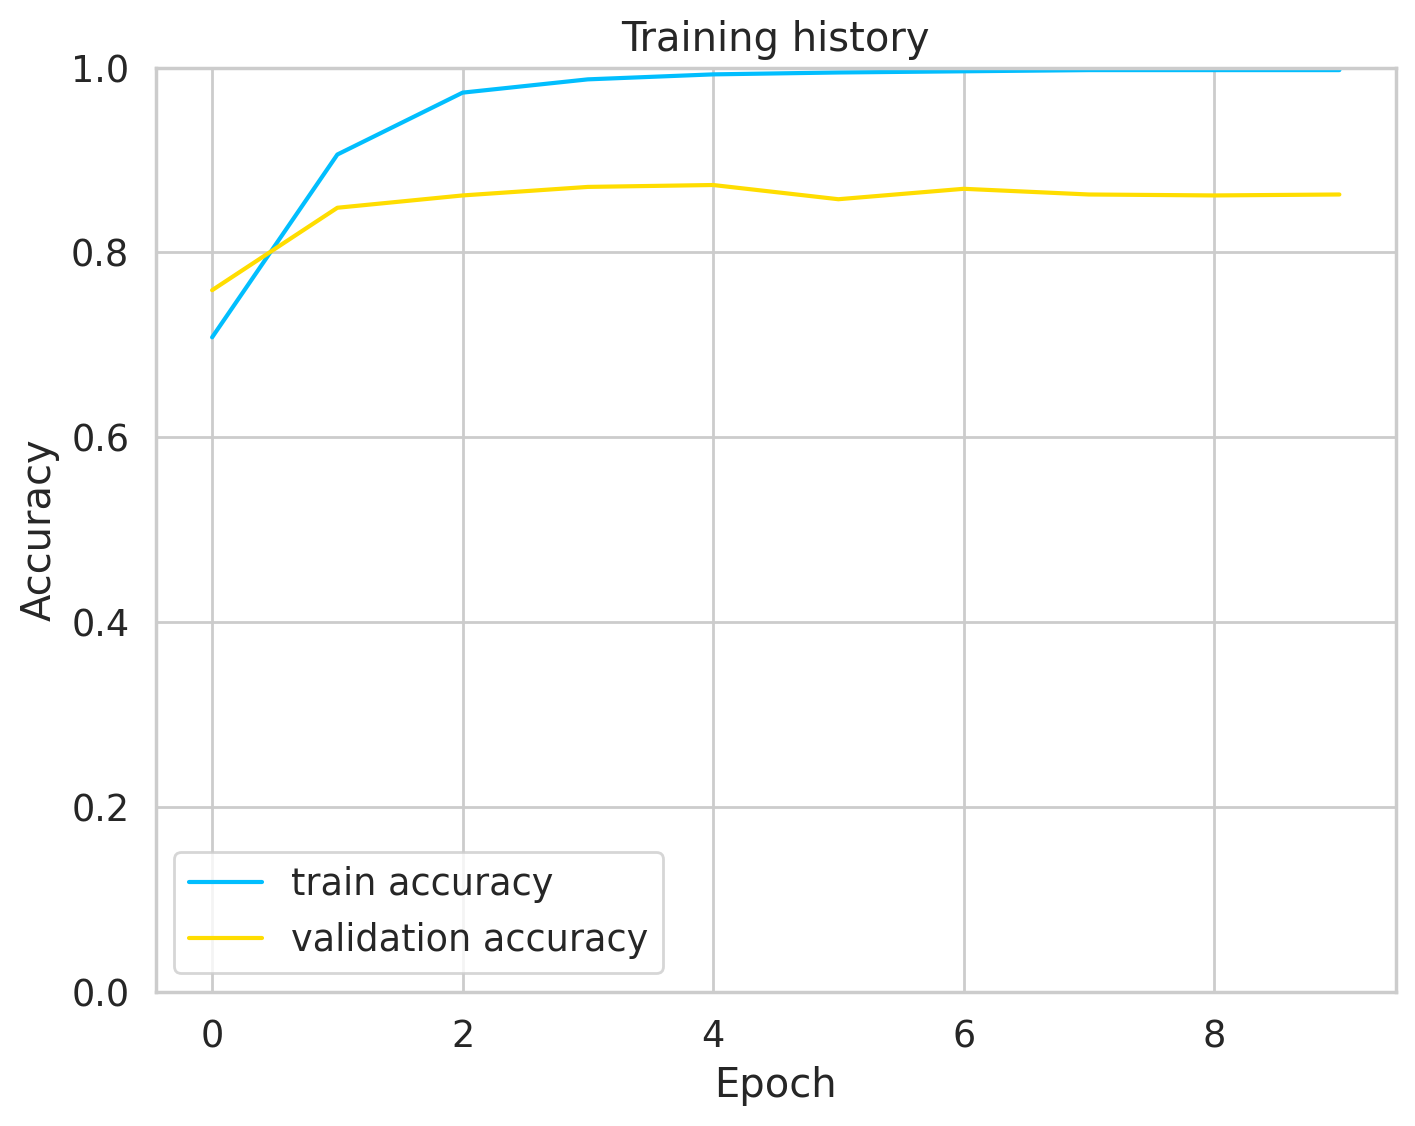

In [28]:
train_acc = [t.cpu().numpy() for t in history['train_acc']]
val_acc = [t.cpu().numpy() for t in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [29]:
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('/content/best_model_state.bin'))
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at publichealthsurveillance/PHS-BERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
df_test.head()

,PID,text,sentiment
0,test_pid_1,Im scared : This is it. I lie to myself every ...,0
1,test_pid_2,New to this but just wanted to vent : I just f...,0
2,test_pid_3,I’m sad : It’s kinda always been an issue. I w...,0
3,test_pid_4,Lonely but not alone. : All of my immediately ...,0
4,test_pid_5,This year has been trash. : I dont know why I’...,0


In [31]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions =[]
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values


In [33]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print("test_acc : ", test_acc)
print("test_loss : ", test_loss)

test_acc :  tensor(0.4829, device='cuda:0', dtype=torch.float64)
test_loss :  3.344130800903173


In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [35]:
class_names = ["moderate", "not depression", "depression"]

print(classification_report(y_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

      moderate       0.78      0.38      0.51      2169
not depression       0.37      0.67      0.48       848
    depression       0.26      0.71      0.38       228

      accuracy                           0.48      3245
     macro avg       0.47      0.59      0.46      3245
  weighted avg       0.63      0.48      0.50      3245



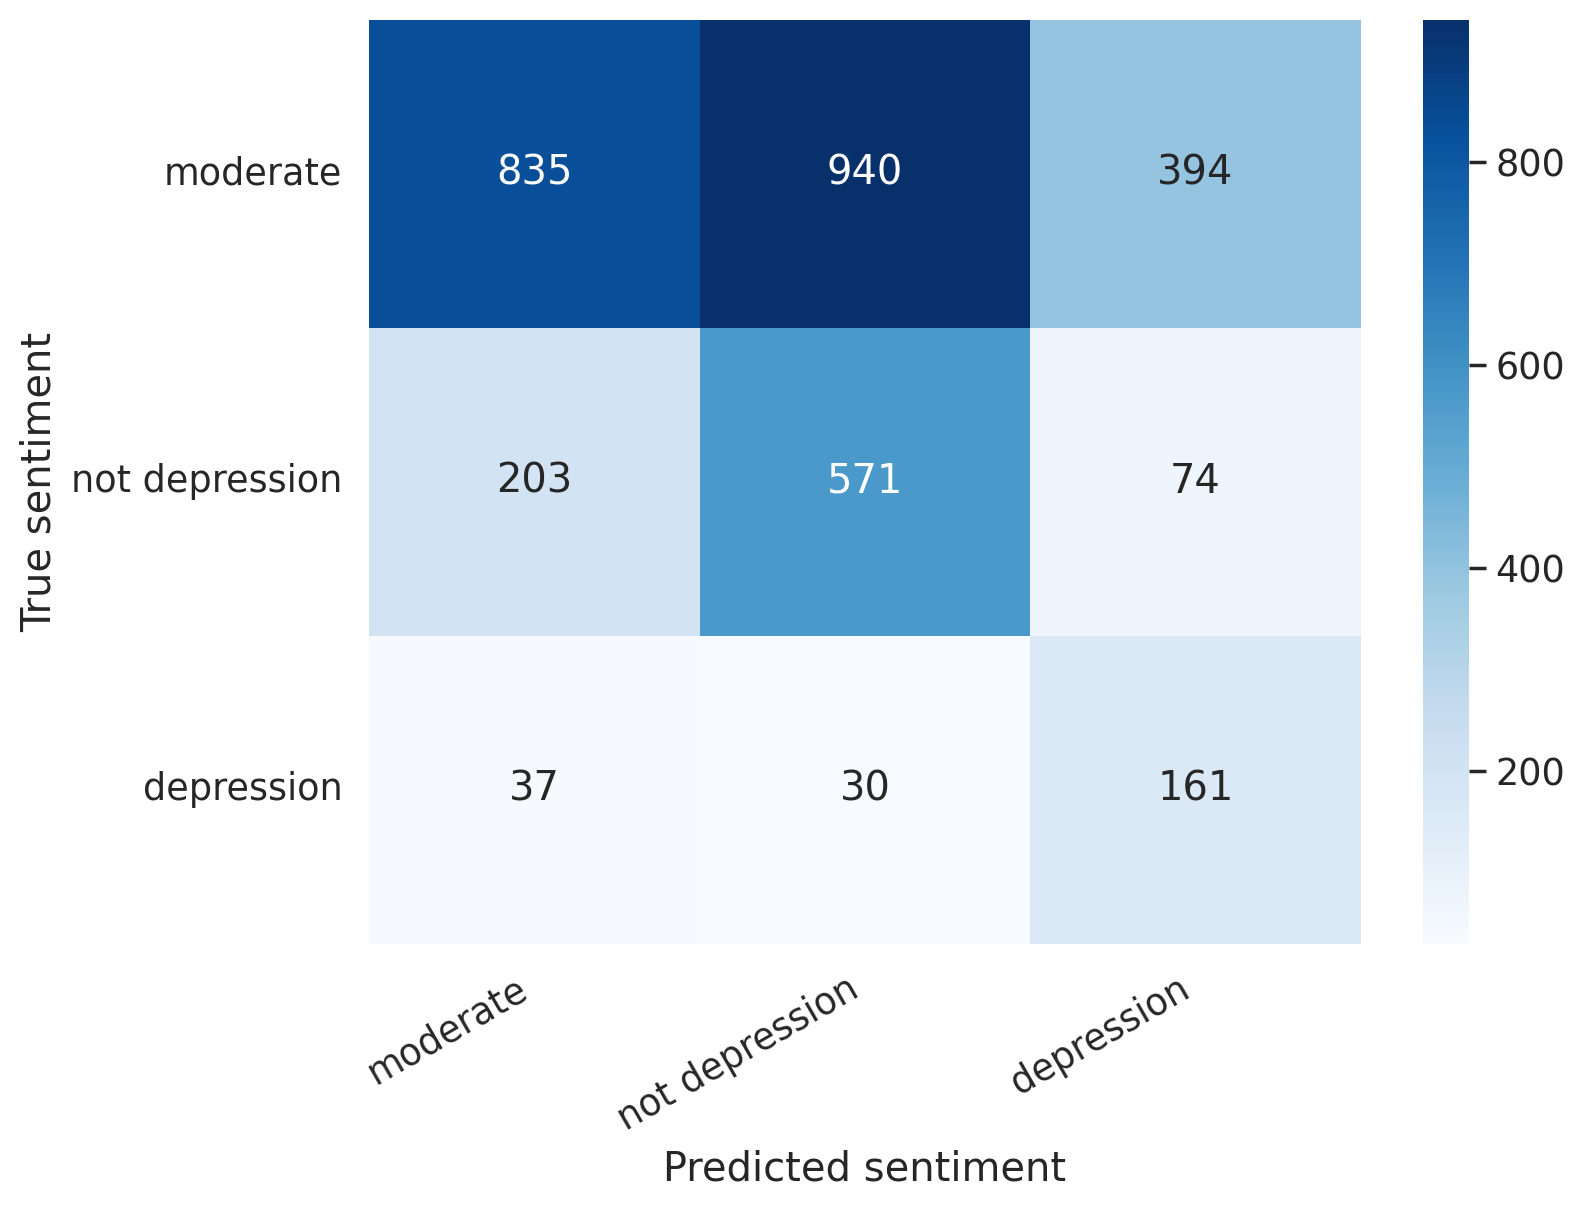

In [36]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

i fucking hate it : I’ve never felt so low, I’ve never seen so much
blood.I really don’t think that therapy or anti depressants will help.
I’m at my breaking point and I hate myself so fucking much since there
is no one to blame but me.

True sentiment: moderate
Predicted sentiment: depression


(0.0, 1.0)

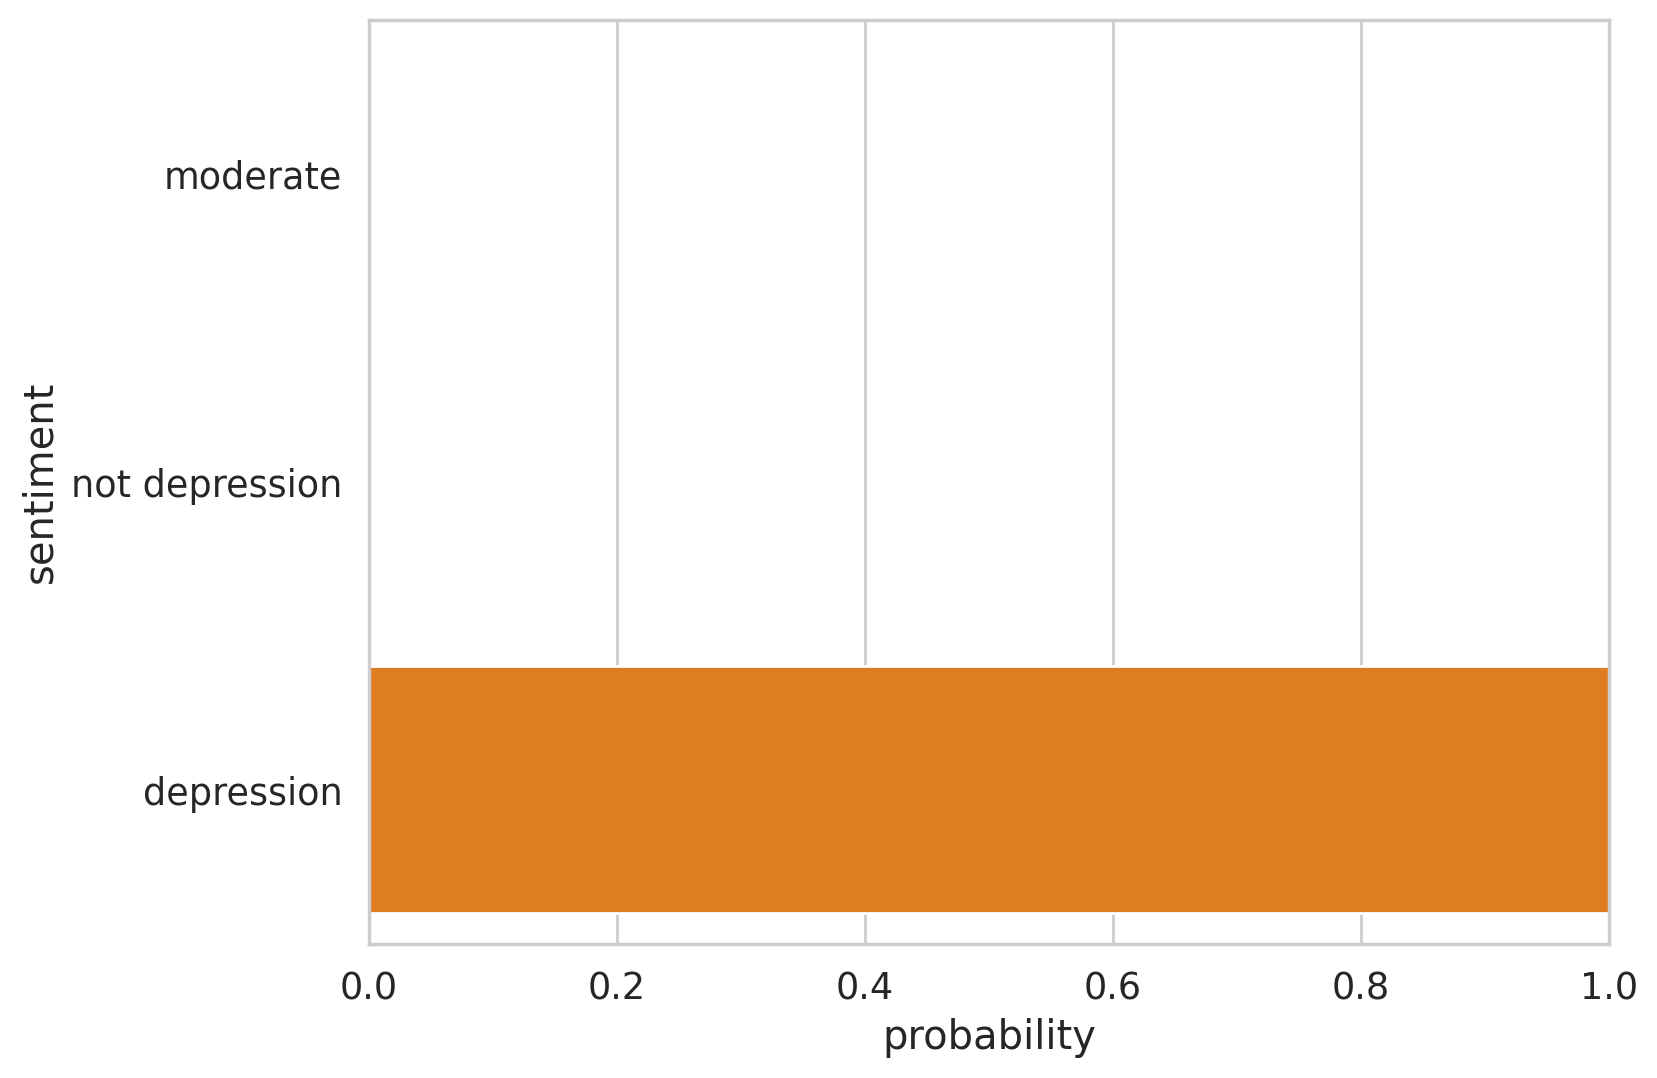

In [37]:
from textwrap import wrap

idx = 635
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
print(f'Predicted sentiment: {class_names[pred_sentiment]}')

# Now we can look at the confidence of each sentiment of our model:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])


In [38]:
review_text = "I've been feeling really down lately, I can't seem to find joy in anything."


encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)


print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review text: I've been feeling really down lately, I can't seem to find joy in anything.
Sentiment  : moderate
